# Example 1: Normal distributed noise

In [1]:
from pyDOE import *
from scipy import stats
from scipy.stats import qmc, norm
import matplotlib.pyplot as plt
import numpy.random as R
import global_as_gaussian_quad as global_as_gaussian_quad
import global_as as global_as

In [2]:
Q = np.identity(10)
dim = 10
Q[:dim,:dim] = stats.ortho_group.rvs(dim=dim)
a = 10**(np.array([2,-1,-1.5,-2,-2.5,-3,-3.5,-4,-4.5,-5]))

## AS results
First, we apply active subspace method for different cases.

In [19]:
epsilon = 0.00001
def dFunc(x):
    chi = x.shape[0]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

def Func(x1): 
    x = (x1@Q)**2*np.sqrt(a) 
    return np.sum(x,axis=1)

chi = 10000
epsilon = 10**-6
z = R.normal(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.sqrt(chi)
uo, so, vho = np.linalg.svd(deriv.astype(float), full_matrices=False)  
so = so**2

def Func(x1): 
    x = (x1@Q)**2*np.sqrt(a) 
    return np.sum(x,axis=1) + R.normal(0,(0.01),x1.shape[0])

z = R.normal(0, 1, (chi, dim))
u0list = []
s0list = []
for epsilon in [0.1,0.001,10**-5]:
    deriv = dFunc(z)
    deriv /= np.sqrt(chi)
    u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=False) 
    s0 = s0**2
    u0list.append(u0)
    s0list.append(s0)

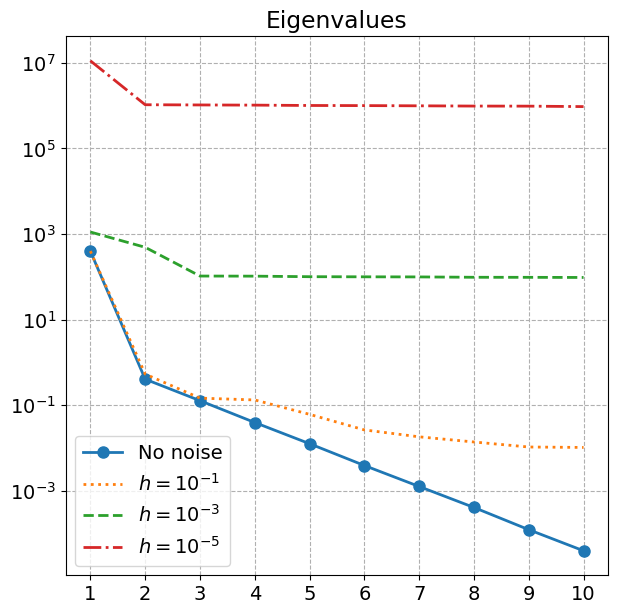

In [20]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.semilogy(range(1 ,k+1), so, 'o-',markersize=8,linewidth=2,label = 'No noise')
plt.semilogy(range(1 ,k+1), s0list[0], ':',markersize=12,linewidth=2,label = '$h=10^{-1}$')
plt.semilogy(range(1 ,k+1), s0list[1], '--',markersize=12,linewidth=2,label = '$h=10^{-3}$')
plt.semilogy(range(1 ,k+1), s0list[2], '-.',markersize=12,linewidth=2,label = '$h=10^{-5}$')

plt.title('Eigenvalues')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))

plt.legend()
plt.savefig(f'gas_paper/as_ev_4.png')

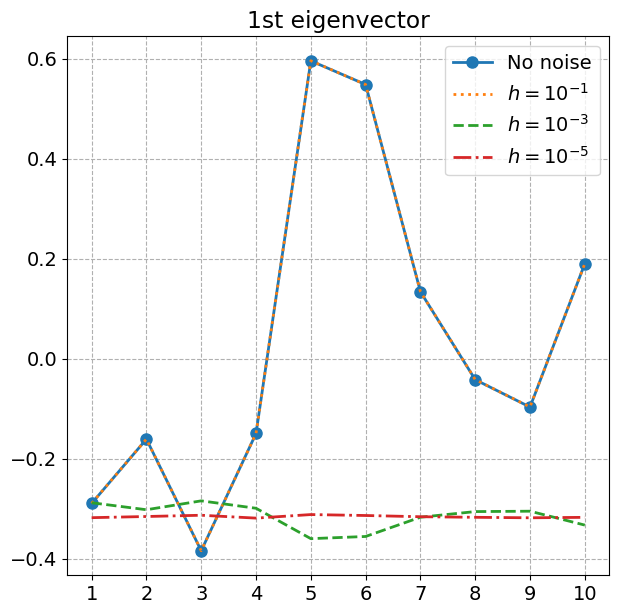

In [21]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.plot(range(1 ,k+1), uo[:,0], 'o-',markersize=8,linewidth=2,label = 'No noise')
plt.plot(range(1 ,k+1), u0list[0][:,0], ':',markersize=12,linewidth=2,label = '$h=10^{-1}$')
plt.plot(range(1 ,k+1), u0list[1][:,0], '--',markersize=12,linewidth=2,label = '$h=10^{-3}$')
plt.plot(range(1 ,k+1), u0list[2][:,0], '-.',markersize=12,linewidth=2,label = '$h=10^{-5}$')

plt.title('1st eigenvector')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))

plt.legend()
plt.savefig(f'gas_paper/as_eve_4.png')

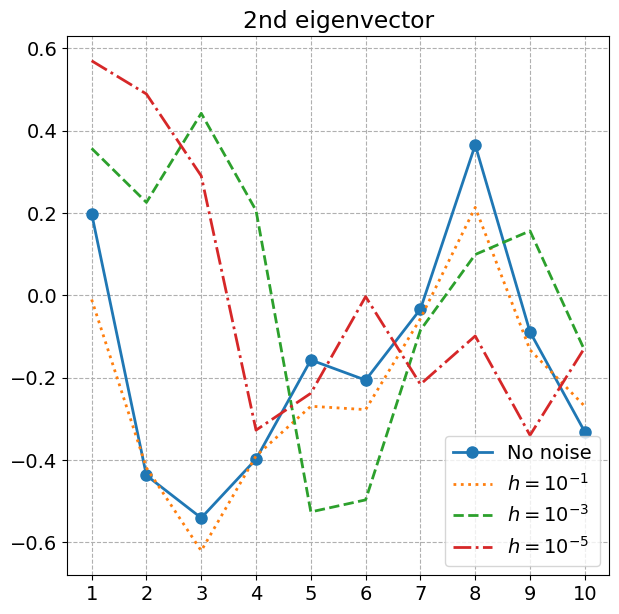

In [23]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.plot(range(1 ,k+1), uo[:,1], 'o-',markersize=8,linewidth=2,label = 'No noise')
plt.plot(range(1 ,k+1), -u0list[0][:,1], ':',markersize=12,linewidth=2,label = '$h=10^{-1}$')
plt.plot(range(1 ,k+1), u0list[1][:,1], '--',markersize=12,linewidth=2,label = '$h=10^{-3}$')
plt.plot(range(1 ,k+1), u0list[2][:,1], '-.',markersize=12,linewidth=2,label = '$h=10^{-5}$')

plt.title('2nd eigenvector')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))

plt.legend()
plt.savefig(f'gas_paper/as_eve2_4.png')

## GAS results

In [25]:
def Func(x1): 
    x = (x1@Q)**2*np.sqrt(a)
    return np.sum(x,axis=1)
chi = 10000
#uo, so = global_as.GAS(Func,dim,chi,100,100,shiftedSobol=True) 
M2 = 10
# fd_result = global_as_gaussian_quad.calculate_finite_difference_matrix_normal1(
#             f=Func,
#             X=R.normal(0, 1, (int(chi/2/M2), dim)),
#             n_points=M2
#         )
# uo, so, _ = np.linalg.svd(fd_result.T.astype(float), full_matrices=False)  
# so = so**2
fd_result = global_as_gaussian_quad.calculate_sensitivity_matrix(
            f=Func,
            X=R.normal(0, 1, (int(chi/M2), dim)),
            n_points=int(M2/2)
        )
so, uo = np.linalg.eigh(fd_result.astype(float))  
so = so[::-1]
uo = uo[:, ::-1]

M1p = 10000
M2p = 20
z = R.normal(0, 1, (M1p, dim))
#C_u_1 = global_as.compute_C_u_1(z,Func,uo,M2p)
C_u_1 = global_as_gaussian_quad.calculate_gamma(
    f=Func,
    X=R.normal(0, 1, (M1p, dim)),
    U=uo,
    n_points=M2p
)

In [6]:
C_u_1

[191.0744710228546,
 0.37759982468542264,
 0.595485393505963,
 0.01959739063881404,
 0.04089213144606099,
 0.19744380058175207,
 0.027614097239797703,
 0.14241700198880822,
 0.05600548972056898,
 0.05088763059212679]

In [31]:
def Func(x1): 
    x = (x1@Q)**2*np.sqrt(a) 
    return np.sum(x,axis=1) + R.normal(0,0.0,x1.shape[0])
ulist = []
slist = []
Clist = []
M1p = 10000
M2p = 50
for M2 in [10,20]:
    M1 = int(chi/M2)
    # fd_result = global_as_gaussian_quad.calculate_finite_difference_matrix_normal1(
    #         f=Func,
    #         X=R.normal(0, 1, (int(chi/2/M2), dim)),
    #         n_points=M2
    #     )
    # u0, s0, _ = np.linalg.svd(fd_result.T.astype(float), full_matrices=False)  
    # s0 = s0**2
    # u0, s0 = global_as.GAS(Func,dim,chi,M1,M2,shiftedSobol=True) 
    fd_result = global_as_gaussian_quad.calculate_sensitivity_matrix(
            f=Func,
            X=R.normal(0, 1, (int(chi/M2), dim)),
            n_points=int(M2/2)
        )
    s0, u0 = np.linalg.eigh(fd_result.astype(float))  
    s0 = s0[::-1]
    u0 = u0[:, ::-1]
    z = R.normal(0, 1, (M1p, dim))
    ulist.append(u0)
    slist.append(s0)
    #Clist.append((global_as.compute_C_u_1(z,Func,u0,M2p)))
    Clist.append(global_as_gaussian_quad.calculate_gamma(
    f=Func,
    X=z,
    U=u0,
    n_points=M2p
    ))

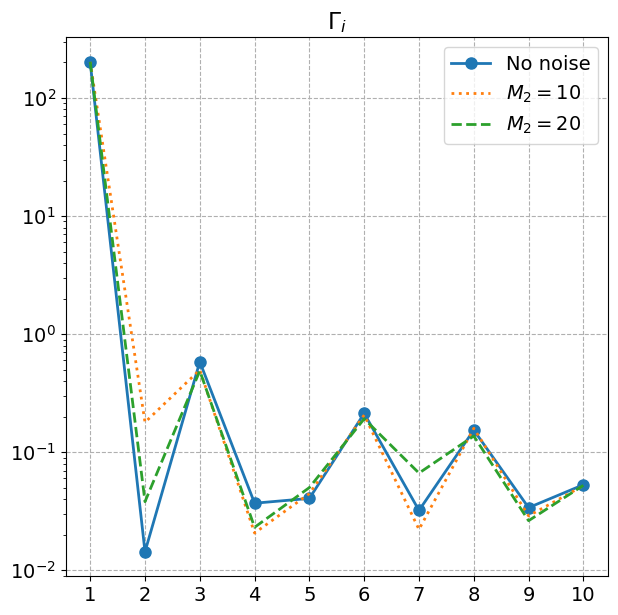

In [32]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.semilogy(range(1 ,k+1), C_u_1, 'o-',markersize=8,linewidth=2,label = 'No noise')
plt.semilogy(range(1 ,k+1), Clist[0], ':',markersize=12,linewidth=2,label = '$M_2=10$')
plt.semilogy(range(1 ,k+1), Clist[1], '--',markersize=12,linewidth=2,label = '$M_2=20$')

plt.title(r"$\Gamma_i$")
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))

plt.legend()
#plt.show()
plt.savefig(f'gas_paper/gas_ev_4.png')

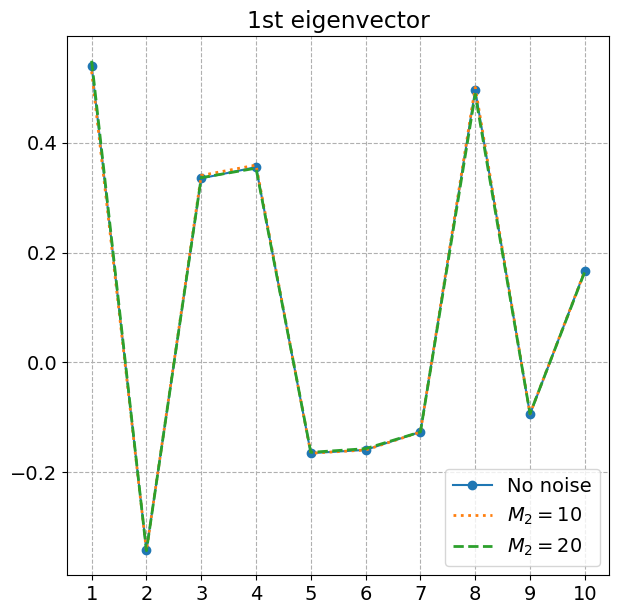

In [13]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.plot(range(1 ,k+1), uo[:,0], 'o-',label = 'No noise')
plt.plot(range(1 ,k+1), ulist[0][:,0], ':',markersize=12,linewidth=2,label = '$M_2=10$')
plt.plot(range(1 ,k+1), -ulist[1][:,0], '--',markersize=12,linewidth=2,label = '$M_2=20$')

plt.title('1st eigenvector')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))

plt.legend()
#plt.show()
plt.savefig(f'gas_paper/gas_eve_4.png')

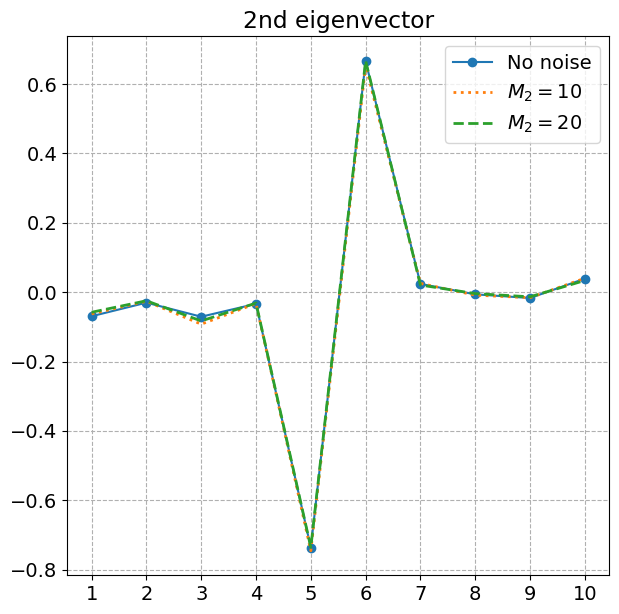

In [58]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.plot(range(1 ,k+1), uo[:,1], 'o-',label = 'No noise')
plt.plot(range(1 ,k+1), ulist[0][:,1], ':',markersize=12,linewidth=2,label = '$M_2=10$')
plt.plot(range(1 ,k+1), -ulist[1][:,1], '--',markersize=12,linewidth=2,label = '$M_2=20$')

plt.title('2nd eigenvector')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))

plt.legend()
plt.savefig(f'gas_paper/gas_eve2_4.png')